# DC$\pi$BO - Simulator-based Experiment

## Imports

In [1119]:
%load_ext autoreload
%autoreload 2

# Imports
## Common libs
import pandas as pd
import numpy as np
from scipy import stats
import random
import pickle
from itertools import cycle, chain
from copy import deepcopy
from datetime import datetime
from collections import OrderedDict

## Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.pyplot import rc

## Graphs
from networkx.drawing import nx_agraph
import networkx as nx
from graphviz import Source
import pygraphviz

## GPs
from GPy.kern import RBF
from GPy.models.gp_regression import GPRegression

## DCBO Utils
import sys
sys.path.append("../../")
from src.utils.utilities import powerset
from src.utils.sem_utils.sem_estimate import build_sem_hat
from src.utils.sequential_intervention_functions import get_interventional_grids
from src.experimental.experiments import optimal_sequence_of_interventions, run_methods_replicates
from src.experimental.analyse_results import get_relevant_results, elaborate
from src.utils.plotting import plot_expected_opt_curve_paper

## Optimisation Algos
from src.methods.dcbo import DCBO
from src.methods.bo import BO
from src.methods.pibo import PIBO
from src.methods.dcpibo import DCPIBO

## YT
import random
from gym import spaces
from numpy import repeat
from stable_baselines3.common.env_checker import check_env

sys.path.append("../Yawning_Titan")
from yawning_titan.integrations.dcbo.dcbo_agent import DCBOAgent
from yawning_titan.envs.generic.core.blue_interface import BlueInterface
from yawning_titan.envs.generic.core.network_interface import NetworkInterface
from yawning_titan.envs.generic.core.red_interface import RedInterface
from yawning_titan.envs.generic.generic_env import GenericNetworkEnv
from yawning_titan.envs.generic.helpers import network_creator

random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Utility Functions

In [1120]:
def power_list(input_list, exponent):
    '''Raises each element of the given input_list to the desired exponent'''
    
    return_list = []
    
    for element in input_list:
        if element >= 0:
            raised_element = element**exponent
        else:
            raised_element = -(abs(element)**exponent)
        return_list.append(raised_element)
        
    return return_list

In [1121]:
def compute_statistics(y_function, standard_deviation):
    '''Computes all the necessary lists associated to the Normal Distribution'''
    
    return_variates = []
    return_amps = []
    return_pdfs = []
    
    for mean in y_function:
        return_variates.append(stats.norm.rvs(mean, standard_deviation, 10))
        
        amp = np.linspace(mean-5*standard_deviation, mean+5*standard_deviation, 10)
        return_amps.append(amp)
        
        return_pdfs.append(stats.norm.pdf(amp, mean, standard_deviation))
    
    return return_variates, return_amps, return_pdfs

In [1122]:
def normalise_pdfs(pdfs_list):
    '''Normalises the PDFs between 0 and 1'''
    
    return_normalised_pdfs_list = []
    
    for pdf_list in pdfs_list:
        temp_list = []
        
        pdf_min = min(pdf_list)
        pdf_max = max(pdf_list)
        
        for pdf_value in pdf_list:
            temp_list.append(round((pdf_value-pdf_min)/(pdf_max-pdf_min),2))
        
        return_normalised_pdfs_list.append(temp_list)
        
    return return_normalised_pdfs_list

In [1123]:
def regret_priors(start_prior):
    '''Adds regret'''
    
    return_raised_priors = []
    
    for i in range(1,N+1):
        temp = []
        gamma = beta/i
        
        for p_list in start_prior:
            temp.append(power_list(p_list, gamma))
            
        return_raised_priors.append(temp)
    
    return return_raised_priors

In [1124]:
def predict_optima_regret(iterations, time_steps, regret_priors, normalised_pdfs):
    '''Computes the prediction for each time-step and each iteration, according to the effect of gamma (regret)'''
    
    return_predictions = []
    
    for iteration in range(iterations):
        temp = []
        
        for time_step in range(time_steps):
            if(min(regret_priors[iteration][time_step])+max(regret_priors[iteration][time_step]))<0:
                optimum = min(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
            else:
                optimum = max(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
                              
            temp.append(optimum)
                              
        return_predictions.append(temp)
                              
    return return_predictions

## Problem Setup
* Use YAWNING TITAN to simulate data for a range of probabilities for $P$ and $I$
* Generate data for 25 timesteps in each environment
* Use BO, CBO and DCBO to take that data and determine the optimal value for $P$ and $I$ in the final 3 timesteps

### DAG Definition


In [1125]:
T = 3

In [1126]:
def picshat_graph(start_time: int, stop_time: int, verbose=False):
    """
    Helper function to construct our DAG as a NetworkX graph.
    """
    assert start_time <= stop_time

    spatial_edges, ranking = [], []
    nodes = ["P", "I", "H", "A", "C", "T", "S"]
    node_count = len(nodes)
    connections = node_count * "{}_{} -> {}_{}; "
    edge_pairs = ["P", "A", "P", "H", "I", "A", "I", "S", "C", "H", "C", "T", "A", "T"]
    pair_count = len(edge_pairs)
    for t in range(start_time, stop_time + 1):
        space_idx = pair_count * [t]
        iters = [iter(edge_pairs), iter(space_idx)]
        inserts = list(chain(map(next, cycle(iters)), *iters))
        spatial_edges.append(connections.format(*inserts))
        ranking.append(
            "{{ rank=same; {} }} ".format(
                " ".join([item + "_{}".format(t) for item in nodes])
            )
        )
    ranking = "".join(ranking)
    spatial_edges = "".join(spatial_edges)

    temporal_edges = []
    NUMBER_TRANS_EDGES = 2
    connections = NUMBER_TRANS_EDGES * "{}_{} -> {}_{}; "
    for t in range(stop_time):
        edge_pairs = ["C", "C", "S", "S"]
        temporal_idx = node_count * [t, t + 1]
        iters = [iter(edge_pairs), iter(temporal_idx)]
        inserts = list(chain(map(next, cycle(iters)), *iters))
        temporal_edges.append(connections.format(*inserts))
    temporal_edges.append("")
    temporal_edges = "".join(temporal_edges)
    graph = "digraph {{ rankdir=LR; {} {} {} }}".format(
        spatial_edges, temporal_edges, ranking
    )
    if verbose:
        return Source(graph)
    return graph



In [1127]:
dag_view = picshat_graph(0, T - 1, verbose=True)
dag = nx_agraph.from_agraph(pygraphviz.AGraph(dag_view.source))


### Data Generation 
The following cell uses YAWNING TITAN to set up 10 different environments, each with a random value for $P$ and $I$, and runs them for 25 timesteps. 

In [1128]:
def create_env(use_same_net=False):
    """
    Helper function to create an environment.

    Args:
        use_same_net: If true uses a saved network, otherwise creates a new network

    Returns: The env

    """
    settings_path = "dcbo_config.yaml"

    if use_same_net:
        matrix, node_positions = network_creator.load_network("dcbo_base_net.txt")
    else:
        matrix, node_positions = network_creator.create_mesh(size=10)

    network_interface = NetworkInterface(
        matrix, node_positions, settings_path=settings_path
    )

    red = RedInterface(network_interface)
    blue = BlueInterface(network_interface)

    number_of_actions = blue.get_number_of_actions()

    env = GenericNetworkEnv(
        red,
        blue,
        network_interface,
        number_of_actions,
        show_metrics_every=10,
        collect_additional_per_ts_data=True,
    )

    # check_env(env, warn=True)

    env.reset()

    return env

# Creates all 10 envs
all_envs = [create_env() for i in range(10)]
agent = DCBOAgent(all_envs[0].action_space, [0.5, 0.5])

TIMESTEPS = 25
COSTS = {"restore_node": 1, "isolate": 1, "do_nothing": 0, "compromise": 10}

centralities = nx.degree_centrality(all_envs[0].network_interface.current_graph)
slice_data = {k: [] for k in "PICSHAT"}

for counter, current_env in enumerate(all_envs):
    # Init data
    slice_p, slice_i, slice_s, slice_h, slice_c, slice_a, slice_t = (list() for i in range(7))
    
    # Init probabilities
    current_env.reset()
    agent.reset()

    w1, w2 = (
        random.gauss(0.5, 0.167),
        random.gauss(0.5, 0.167),
    )
    agent.update_probabilities([w1, w2])

    for i in range(TIMESTEPS):
        done = False
        current_step = 0

        action = agent.predict("", "", "", current_env)
        env_observation, reward, done, notes = current_env.step(action)

        c_cost = (COSTS["compromise"] * sum(notes["end_state"].values())) ** 1.5
        action_cost = COSTS.get(notes["blue_action"], 0)
        surface = sum(
            map(
                lambda x: not x[0] and not x[1],
                zip(
                    notes["end_state"].values(),
                    current_env.network_interface.get_all_isolation().values(),
                ),
            )
        )
        # Append P, I and S
        slice_p.append(agent.probabilities[0])
        slice_i.append(agent.probabilities[1])
        slice_s.append(surface) 
        
        # Calculate and append H
        h = 0
        node_states = current_env.network_interface.get_all_node_compromised_states()
        node_iso = current_env.network_interface.get_all_isolation()
        comp_nodes = [k for k in node_states if node_states[k] == 1]
        isolated_nodes = [k for k in node_iso if node_iso[k]]
        for node in comp_nodes:
            conn_nodes = current_env.network_interface.get_current_connected_nodes(node)
            for c in conn_nodes:
                if c in isolated_nodes:
                    continue
                h += current_env.network_interface.get_single_node_vulnerability(c)
        slice_h.append(h)
        # Append C, A and T
        slice_c.append(c_cost)
        slice_a.append(action_cost)
        slice_t.append(action_cost + c_cost)

    slice_data["P"].append(np.asarray(slice_p))
    slice_data["I"].append(np.asarray(slice_i))
    slice_data["S"].append(np.asarray(slice_s))
    slice_data["H"].append(np.asarray(slice_h))
    slice_data["C"].append(np.asarray(slice_c))
    slice_data["A"].append(np.asarray(slice_a))
    slice_data["T"].append(np.asarray(slice_t))

for k in slice_data.keys():
    slice_data[k] = np.asarray(slice_data[k])

--Game over--
Total number of Games Played:  10
Stats over the last 10 games:
Average episode length:  6 

Blue Won    Red Won
----------  ---------
0           10
0.0%        100.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
restore_node                 3  50.0%
connect                      2  33.33%
isolate                      1  16.67%





### Model Construction

In [1129]:
def fit_gp(
    x,
    y,
    lengthscale=1.0,
    variance=1.0,
    noise_var=1.0,
    ard=False,
    n_restart=10,
    seed: int = 0,
):
    """
    Helper function to fit a GP
    """
    kernel = RBF(x.shape[1], ARD=ard, lengthscale=lengthscale, variance=variance)
    model = GPRegression(X=x, Y=y, kernel=kernel, noise_var=noise_var)
    model.optimize_restarts(n_restart, verbose=False, robust=True)
    return model


In [1130]:
time_vector = np.tile(
    np.linspace(0, slice_data["P"].shape[1] - 1, slice_data["P"].shape[1]),
    10
)[:, np.newaxis]


In [1131]:
# Fit our GPs for t=0 (so no inter-timeslice dependencies)
model_P = fit_gp(time_vector, np.hstack(slice_data["P"])[:, np.newaxis])
model_I = fit_gp(time_vector, np.hstack(slice_data["I"])[:, np.newaxis])
model_S = fit_gp(
    np.hstack(slice_data["I"])[:, np.newaxis], np.hstack(slice_data["S"])[:, np.newaxis]
)
model_C = fit_gp(time_vector, np.hstack(slice_data["C"])[:, np.newaxis])
model_H = fit_gp(
    np.hstack(
        (
            np.hstack(slice_data["P"])[:, np.newaxis],
            np.hstack(slice_data["C"])[:, np.newaxis],
        )
    ), 
    np.hstack(slice_data["H"])[:, np.newaxis],
)
model_A = fit_gp(
    np.hstack(
        (
            np.hstack(slice_data["P"])[:, np.newaxis],
            np.hstack(slice_data["I"])[:, np.newaxis],
        )
    ),
    np.hstack(slice_data["A"])[:, np.newaxis],
)
model_T = fit_gp(
    np.hstack(
        (
            np.hstack(slice_data["C"])[:, np.newaxis],
            np.hstack(slice_data["A"])[:, np.newaxis],
        )
    ),
    np.hstack(slice_data["T"])[:, np.newaxis],
)


 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Warning - optimization restart 1/10 failed
Warning - optimization restart 2/10 failed
Warning - optimization restart 3/10 failed
Warning - optimization restart 7/10 failed
Warning - optimization restart 10/10 failed


In [1132]:
functions_0 = {
    "P": model_P,
    "I": model_I,
    "S": model_S,
    "H": model_H,
    "C": model_C,
    "A": model_A,
    "T": model_T,
}

In [1133]:
# Getting slice_data in the right form, based on the DAG
S_AR, H_AR, C_AR, A_AR, T_AR = [], [], [], [], []

for i in range(slice_data["P"].shape[0]):
    S_AR.append(
        np.transpose(np.vstack((slice_data["C"][i][:-1],slice_data["I"][i][1:],slice_data["S"][i][1:])))
    )
    C_AR.append(
        np.transpose(np.vstack((slice_data["H"][i][:-1],slice_data["C"][i][1:])))
    )
    H_AR.append(
        np.transpose(np.vstack((slice_data["P"][i][1:],slice_data["C"][i][1:],slice_data["H"][i][1:])))
    )
    A_AR.append(
        np.transpose(np.vstack((slice_data["P"][i][1:],slice_data["I"][i][1:],slice_data["A"][i][1:])))
    )
    T_AR.append(
        np.transpose(np.vstack((slice_data["C"][i][1:],slice_data["A"][i][1:],slice_data["T"][i][1:])))
    )

S_AR = np.vstack(S_AR)
H_AR = np.vstack(H_AR)
C_AR = np.vstack(C_AR)
A_AR = np.vstack(A_AR)
T_AR = np.vstack(T_AR)


In [1134]:
model_S_t = fit_gp(S_AR[:, :-1], S_AR[:, -1][:, np.newaxis])
model_H_t = fit_gp(H_AR[:, :-1], H_AR[:, -1][:, np.newaxis])
model_C_t = fit_gp(C_AR[:, :-1], C_AR[:, -1][:, np.newaxis])
model_A_t = fit_gp(A_AR[:, :-1], A_AR[:, -1][:, np.newaxis])
model_T_t = fit_gp(T_AR[:, :-1], T_AR[:, -1][:, np.newaxis])


Warning - optimization restart 6/10 failed


In [1135]:
functions_t = {
    "P": model_P,
    "I": model_I,
    "S": model_S_t,
    "H": model_H_t,
    "C": model_C_t,
    "A": model_A_t,
    "T": model_T_t,
}


In [1136]:
class PICSHAT_SEM:
    def __init__(self, functions_0, functions_t):
        self.functions_0 = functions_0
        self.functions_t = functions_t

    def static(self):

        P = (
            lambda noise, time, sample: noise
            + self.functions_0["P"].predict(time * np.ones((1, 1)))[0]
        )

        I = (
            lambda noise, time, sample: noise
            + self.functions_0["I"].predict(time * np.ones((1, 1)))[0]
        )

        S = (
            lambda noise, time, sample: noise
            + self.functions_0["S"].predict(
                np.transpose(np.vstack((sample["I"][time] * np.ones((1, 1)))))
            )[0]
        )

        C = (
            lambda noise, time, sample: noise
            + self.functions_0["C"].predict(time * np.ones((1, 1)))[0]
        )

        H = (
            lambda noise, time, sample: noise
            + self.functions_0["H"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["P"][time] * np.ones((1, 1)),
                            sample["C"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        A = (
            lambda noise, time, sample: noise
            + self.functions_0["A"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["P"][time] * np.ones((1, 1)),
                            sample["I"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        T = (
            lambda noise, time, sample: np.abs(
                noise
                + self.functions_0["T"].predict(
                    np.transpose(
                        np.vstack(
                            (
                                sample["C"][time] * np.ones((1, 1)),
                                sample["A"][time] * np.ones((1, 1)),
                            )
                        )
                    )
                )[0]
            )
        )

        return OrderedDict(
            [("P", P), ("I", I), ("S", S), ("H", H), ("C", C), ("A", A), ("T", T)]
        )

    def dynamic(self):

        P = (
            lambda noise, time, sample: noise
            + self.functions_t["P"].predict(time * np.ones((1, 1)))[0]
        )

        I = (
            lambda noise, time, sample: noise
            + self.functions_t["I"].predict(time * np.ones((1, 1)))[0]
        )

        S = (
            lambda noise, time, sample: noise
            + self.functions_t["S"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["C"][time - 1] * np.ones((1, 1)),
                            sample["I"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        C = (
            lambda noise, time, sample: noise
            + self.functions_t["C"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["H"][time - 1] * np.ones((1,1)),
                        )
                    )
                )
            )[0]
        )

        H = (
            lambda noise, time, sample: noise
            + self.functions_t["H"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["P"][time] * np.ones((1, 1)),
                            sample["C"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        A = (
            lambda noise, time, sample: noise
            + self.functions_t["A"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["P"][time] * np.ones((1, 1)),
                            sample["I"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        T = lambda noise, time, sample: np.abs(
            noise
            + self.functions_t["T"].predict(
                np.transpose(
                    np.vstack(
                        (
                            sample["C"][time] * np.ones((1, 1)),
                            sample["A"][time] * np.ones((1, 1)),
                        )
                    )
                )
            )[0]
        )

        return OrderedDict(
            [("P", P), ("I", I), ("S", S), ("H", H), ("C", C), ("A", A), ("T", T)]
        )


In [1137]:
intervention_domain = {"P": [0.0, 1.0], "I": [0.0, 1.0]}
exploration_sets = list(powerset(["P", "I"]))
n_to_compute = 50
interventional_grids = get_interventional_grids(
    exploration_sets, intervention_domain, size_intervention_grid=n_to_compute
)


In [1138]:
SEM = PICSHAT_SEM(functions_0, functions_t)
initial_structural_equation_model = SEM.static()
structural_equation_model = SEM.dynamic()


In [1139]:
(
    best_s_values,
    best_s_sequence,
    best_objective_values,
    y_stars_all,
    optimal_interventions,
    all_CE,
) = optimal_sequence_of_interventions(
    exploration_sets,
    interventional_grids,
    initial_structural_equation_model,
    structural_equation_model,
    dag,
    T=T,
    model_variables=list("PISHCAT"),
    target_variable="T",
    task="min",
)


In [1140]:
print("Best intervention set:", best_s_sequence)
print("Best intervention values:", best_s_values)
print("Best objective values:", best_objective_values)

Best intervention set: [('P', 'I'), ('P', 'I'), ('P', 'I')]
Best intervention values: [array([0., 0.]), array([0.73469388, 0.28571429]), array([0.73469388, 0.28571429])]
Best objective values: [22.69995641708374, 20.43180274963379, 20.43180274963379]


## Models' executions

In [1141]:
t_axis = np.linspace(1,T,T,dtype=int)
std = 0.1
beta = 1
R = 1
N = 10

In [1142]:
subset_obs_data = deepcopy(slice_data)
for var in subset_obs_data.keys():
    subset_obs_data[var] = subset_obs_data[var][:, -3:]


### Good Prior

In [1143]:
a_param = 0
b_param = best_objective_values[1]
y = a_param*t_axis+b_param # the line on which I assume the optima would be
# y = np.zeros(len(t_axis))
# y[0] = best_objective_values[0]
# y[1:len(t_axis)] = best_objective_values[1]

In [1144]:
all_variates, all_amps, all_pdfs = compute_statistics(y, std)
all_variates_regret = regret_priors(all_variates)

all_pdfs_normalised = normalise_pdfs(all_pdfs)

predicted_optima_regret = predict_optima_regret(N, T, all_variates_regret, all_pdfs_normalised) # this are all the 𝜋s

In [1145]:
# See method for argument details
results = run_methods_replicates(
    G=dag,
    sem=PICSHAT_SEM,
    make_sem_estimator=build_sem_hat,
    base_target_variable='T',
    intervention_domain = intervention_domain,
    methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
    obs_samples = subset_obs_data,
    exploration_sets = exploration_sets,
    priors_regret = predicted_optima_regret,
    total_timesteps = T,
    number_of_trials = N,
    reps = R, # Number of replicates (how many times we run each method)
    n_restart = 1,
    save_data = False,
    n_obs = 5, # The method samples 5 time-series for each replicate
    num_anchor_points = 100,
    sample_anchor_points = True,
    controlled_experiment=False,
    args_sem=[functions_0, functions_t],
    manipulative_variables=["P", "I"]
)

Experiment count:   0%|                                                                           | 0/1 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.43it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.16it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.07it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.73it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.30it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.24it/s]
 /mnt/c/Users/lucal/Desktop/Thesis_Copy/EXTRA/simulator_YT/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



	>>>DCBO



 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Warning - optimization restart 4/10 failed
Warning - optimization restart 5/10 failed
Warning - optimization restart 6/10 failed


 /mnt/c/Users/lucal/Desktop/Thesis_Copy/EXTRA/simulator_YT/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:06<00:12,  6.48s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:18<00:09,  9.55s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.varian


	>>>DCPIBO



 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Warning - optimization restart 4/10 failed
Warning - optimization restart 5/10 failed
Warning - optimization restart 6/10 failed


 /mnt/c/Users/lucal/Desktop/Thesis_Copy/EXTRA/simulator_YT/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:07<00:14,  7.01s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:19<00:10, 10.00s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.varian

### Bad Prior

In [1146]:
bad_a_param = -3
bad_y_param = -2
bad_y = bad_a_param*t_axis+bad_y_param

In [1147]:
bad_all_variates, bad_all_amps, bad_all_pdfs = compute_statistics(bad_y, std)
bad_all_variates_regret = regret_priors(bad_all_variates)

bad_all_pdfs_normalised = normalise_pdfs(bad_all_pdfs)
bad_predicted_optima_regret = predict_optima_regret(N, T, bad_all_variates_regret, bad_all_pdfs_normalised) # this are all the 𝜋s

In [1148]:
bad_results = run_methods_replicates(
    G=dag,
    sem=PICSHAT_SEM,
    make_sem_estimator=build_sem_hat,
    base_target_variable='T',
    intervention_domain = intervention_domain,
    methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
    obs_samples = subset_obs_data,
    exploration_sets = exploration_sets,
    priors_regret = bad_predicted_optima_regret,
    total_timesteps = T,
    number_of_trials = N,
    reps = R, # Number of replicates (how many times we run each method)
    n_restart = 1,
    save_data = False,
    n_obs = 5, # The method samples 5 time-series for each replicate
    num_anchor_points = 100,
    sample_anchor_points = True,
    controlled_experiment=False,
    args_sem=[functions_0, functions_t],
    manipulative_variables=["P", "I"]
)

Experiment count:   0%|                                                                           | 0/1 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.05it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.07it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.04it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.00it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.49it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.31it/s]



	>>>DCBO



 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Warning - optimization restart 4/10 failed
Warning - optimization restart 5/10 failed
Warning - optimization restart 6/10 failed


 /mnt/c/Users/lucal/Desktop/Thesis_Copy/EXTRA/simulator_YT/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:06<00:13,  6.82s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:18<00:09,  9.84s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.varian


	>>>DCPIBO



 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/SIMULATOR_TESTING/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Warning - optimization restart 4/10 failed
Warning - optimization restart 5/10 failed
Warning - optimization restart 6/10 failed


 /mnt/c/Users/lucal/Desktop/Thesis_Copy/EXTRA/simulator_YT/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.

Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:06<00:12,  6.49s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:18<00:10, 10.02s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.varian

## Plotting

In [1149]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.2,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCBO': 'DCBO', 'DCPIBO': 'DCPIBO', 'PIBO': 'PIBO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCBO': 'blue', 'DCPIBO': 'green', 'PIBO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCBO': '-', 'DCPIBO': '--', 'PIBO': 'dashdot', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

In [1150]:
class PlainOffsetScalarFormatter(ScalarFormatter):
    def get_offset(self):
        if len(self.locs) == 0:
            return ''
        if self.orderOfMagnitude:
            pass
            # print("Your plot will likely be labelled incorrectly")
        return "$\\times 10^{-5}+$" + str(round(self.offset, 5))

### Good Prior

In [1151]:
# Since we didn't save the results we cannot use the pickled file so we have to convert results to the correct format
data = get_relevant_results(results=results,replicates=R)
exp_optimal_outcome_values_during_trials, exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=data, 
                                                                         best_objective_values=best_objective_values, 
                                                                         T=T)

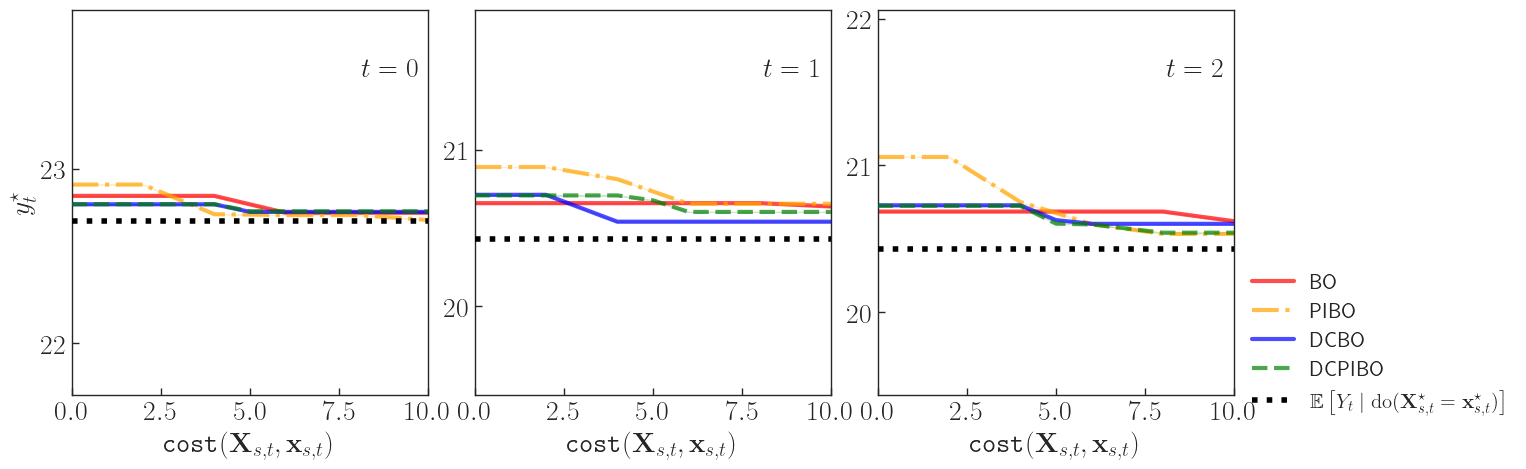

In [1152]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    best_objective_values,
    exp_per_trial_cost,
    exp_optimal_outcome_values_during_trials,
    plot_params, 
    fig_size = (15,5),
    )

### Bad Prior

In [1153]:
bad_data = get_relevant_results(results=bad_results,replicates=R)
bad_exp_optimal_outcome_values_during_trials, bad_exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=bad_data, 
                                                                         best_objective_values=best_objective_values, 
                                                                         T=T)

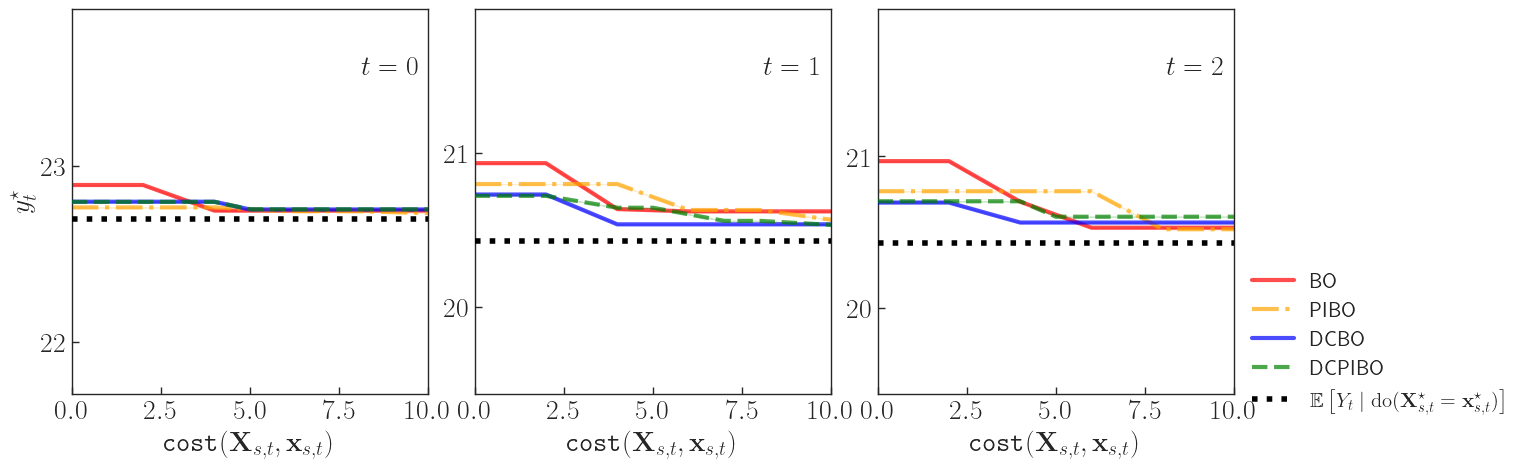

In [1154]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    best_objective_values,
    bad_exp_per_trial_cost,
    bad_exp_optimal_outcome_values_during_trials,
    plot_params, 
    fig_size = (15,5),
    )